Imports

In [1]:
import pathlib
import os
import numpy as np
import torch
from torch import optim
from subgraph_matching_via_nn.data.data_loaders import load_graph
from powerful_gnns.util import S2VGraph
from powerful_gnns.util import load_data_given_graph_list_and_label_map
from powerful_gnns.models.graphcnn import GraphCNN
from powerful_gnns.util import separate_data
from powerful_gnns.classifier_training import train, test
from common.EmbeddingCalculationsService import pairwise_l2_distance, show_distance_matrix, \
    calculate_energy_based_hidden_rep
from subgraph_matching_via_nn.training.PairSampleInfo import Pair_Sample_Info
from subgraph_matching_via_nn.data.annotated_graph import AnnotatedGraph
from subgraph_matching_via_nn.graph_metric_networks.graph_metric_nn import MLPGraphMetricNetwork
from subgraph_matching_via_nn.graph_metric_networks.embedding_metric_nn import EmbeddingMetricNetwork
from subgraph_matching_via_nn.graph_embedding_networks.gnn_embedding_network import GNNEmbeddingNetwork
from subgraph_matching_via_nn.training.trainer.S2VGraphEmbeddingSimilarityMetricTrainer import \
    S2VGraphEmbeddingSimilarityMetricTrainer
from subgraph_matching_via_nn.graph_metric_networks.graph_metric_nn import SingleEmbeddingGraphMetricNetwork
from subgraph_matching_via_nn.graph_metric_networks.graph_metric_nn import S2VGraphEmbeddingGraphMetricNetwork


In [2]:
goal_subcircuit_name = 'alu'
DATA_PATH = 'C:/Users/kogan/OneDrive/Desktop/Research/AMIT/GraphMatching/subgraph_matching_via_nn/data/subcircuits/'
desktop = pathlib.Path(DATA_PATH)
subgraphs = []
labels = []
for circuit_dir in desktop.iterdir():
    if circuit_dir.is_dir():
        for subcircuit_file in circuit_dir.iterdir():
            if subcircuit_file.is_file():
                file_name = subcircuit_file.name
                if file_name == 'full_graph.p':
                    file_rel_path = f"{os.sep}{file_name}"
                    loader_params = {
                     'data_path' : str(circuit_dir),
                     'g_full_path': file_rel_path,
                     'g_sub_path': file_rel_path}

                    sub_graph = \
                        load_graph(type='subcircuit',
                                   loader_params=loader_params)

                    if goal_subcircuit_name in circuit_dir.name:
                        labels.append(1)
                    else:
                        # continue #TODO?
                        labels.append(0)
                    subgraphs.append(sub_graph)

labels = np.array(labels, dtype='float32')
N = len(subgraphs)
N_training = int(2 / 3 * N)

In [3]:
subgraphs = []
labels = []

circuit_base_dir = 'C:\\Users\\kogan\\OneDrive\\Desktop\\Research\\AMIT\\GraphMatching\\subgraph_matching_via_nn\\data\\subcircuits\\'
for circuit_file_name in ['adder_4', 'alu_4', 'alu_8', 'alu_16', 'alu_32', 'mul_4_4', 'mul_4_8', 'mul_8_8', 'mul_16_16', 'mul_16_32']:
    file_rel_path = 'full_graph.p'
    circuit_dir = f"{circuit_base_dir}{circuit_file_name}{os.sep}"
    loader_params = {
     'data_path' : str(circuit_dir),
     'g_full_path': file_rel_path,
     'g_sub_path': file_rel_path}

    sub_graph = \
        load_graph(type='subcircuit',
                   loader_params=loader_params)
    subgraphs.append(sub_graph)
    labels.append(0)
labels[0] = 1

N = len(subgraphs)
N_training = int(2 / 3 * N)

Transform graphs into S2VGraph-s

In [4]:
g_list = []
label_dict = {}
for subgraph, label in zip(subgraphs, labels):
    g_list.append(S2VGraph(subgraph.G, label))

    if not label in label_dict:
        mapped = len(label_dict)
        label_dict[label] = mapped

Process graph features

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

graphs, num_classes = load_data_given_graph_list_and_label_map(g_list, label_dict, degree_as_tag=True, device=device)

# classes: 2
# maximum node tag: 48
# data: 10


Setup model and training

In [6]:
#set up seeds and gpu device
torch.manual_seed(0)
np.random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

##k-fold cross validation. Conduct an experiment on the fold specified by args.fold_idx.
# train_graphs, test_graphs = separate_data(graphs, seed=0, fold_idx=0, n_splits=1)
# train_graphs = graphs[:4]
# test_graphs = graphs[4:]
train_graphs = test_graphs = graphs

model = GraphCNN(num_layers=5, num_mlp_layers = 2, input_dim=train_graphs[0].node_features.shape[1], hidden_dim=64, output_dim=num_classes, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

Train and Test

In [7]:
from livelossplot import PlotLosses

liveloss = PlotLosses(mode='notebook')

filename = ""
epochs = 3
k_update_plot = 25

for epoch in range(1, epochs + 1):
    scheduler.step()

    avg_loss = train(iters_per_epoch=50, batch_size=len(train_graphs), model=model, device=device, train_graphs=train_graphs, optimizer=optimizer, epoch=epoch)
    acc_train, acc_test = test(model, device, train_graphs, test_graphs, epoch)

    if not filename == "":
        with open(filename, 'w') as f:
            f.write("%f %f %f" % (avg_loss, acc_train, acc_test))
            f.write("\n")
    print("")

    print(model.eps)

    if epoch % k_update_plot == 0:
        liveloss.update({'train error': avg_loss.item()})
        liveloss.send()

c:\users\kogan\.virtualenvs\subcircuit_recognition-mmb-fima\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
epoch: 1: 100%|██████████| 50/50 [00:02<00:00, 17.72batch/s]


loss training: 1.255096
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0., 0., 0., 0.], device='cuda:0', requires_grad=True)


epoch: 2: 100%|██████████| 50/50 [00:01<00:00, 27.54batch/s]


loss training: 0.113457
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0., 0., 0., 0.], device='cuda:0', requires_grad=True)


epoch: 3: 100%|██████████| 50/50 [00:01<00:00, 26.17batch/s]

loss training: 0.274114
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0., 0., 0., 0.], device='cuda:0', requires_grad=True)


Show predictions

In [8]:
pred = model(train_graphs).max(1, keepdim=True)[1]
print(pred)

tensor([[0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], device='cuda:0')


In [9]:
pred = model(test_graphs).max(1, keepdim=True)[1]
print(pred)

tensor([[0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], device='cuda:0')


show all distances matrix (margin)

In [10]:
all_embeddings = model.get_embedding(graphs)

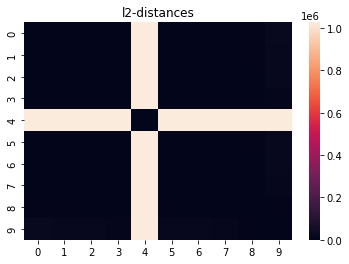

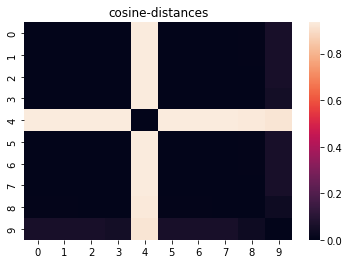

In [11]:
l2_dists = pairwise_l2_distance(all_embeddings)

rounding_constant = 10 ** 3
cos_dists = torch.round(calculate_energy_based_hidden_rep(all_embeddings, threshold=-1) * rounding_constant) / rounding_constant

show_distance_matrix(l2_dists, "l2-distances")
show_distance_matrix(cos_dists, "cosine-distances")

what is the smallest margin?

In [12]:
def get_min_non_diagonal_entry(tensor_):
    tensor_with_inf_diag = tensor_ + torch.diag_embed(torch.ones(tensor_.shape[0], device=device) * float("inf"))
    return torch.min(tensor_with_inf_diag).item()

print(get_min_non_diagonal_entry(l2_dists))
print(get_min_non_diagonal_entry(cos_dists))

0.00036881212145090103
0.0


Contrastive loss training

Assemble graph pairs data

In [13]:
train_samples_list = []
reference_subgraph_index = 0
reference_subgraph = subgraphs[reference_subgraph_index]
negative_examples_subgraphs = subgraphs[1:]

for subgraph in subgraphs:
    if subgraph == reference_subgraph:
        is_negative_example = False
    else:
        is_negative_example = True

    G1_annotated = AnnotatedGraph(subgraph.G)
    G2_annotated = AnnotatedGraph(reference_subgraph.G)
    train_samples_list.append(Pair_Sample_Info(
        subgraph=G1_annotated,
        masked_graph=G2_annotated,
        is_negative_sample=torch.tensor(is_negative_example)))

val_samples_list = train_samples_list

Define GNN model

In [14]:
# input dim matches the node mask (w) shape
input_dim = S2VGraphEmbeddingSimilarityMetricTrainer.get_model_expected_input_dim(train_samples_list[0])
model = GraphCNN(num_layers=5, num_mlp_layers = 2, input_dim=input_dim, hidden_dim=64, output_dim=num_classes, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device).to(device)

Define graph metric to train, and the trainer

In [15]:
solver_params = {
    "device": torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    "lr": 1e-3, "weight_decay": 1e-3,
    "max_epochs": 10000,
    "cycle_patience": 5, "step_size_up": 10, "step_size_down": 10,
    "loss_convergence_threshold": None,
    "train_loss_convergence_threshold": 1e-3,
    "successive_convergence_min_iterations_amount": 5,
    "margin_loss_margin_value": 5,
    "max_grad_norm": 0.1,
    "k_update_plot": 50,
    "batch_size": len(subgraphs),
}

problem_params = {"input_dim": input_dim}

dump_base_path = f".{os.sep}runlogs"

def init_embedding_net_and_trainer(model):

    loss_fun = torch.nn.MSELoss()
    embedding_metric_network = EmbeddingMetricNetwork(loss_fun=loss_fun)

    gnn_embedding_nn = GNNEmbeddingNetwork(gnn_model=model)

    # embedding_nns = \
    #     [
    #         GNNEmbeddingNetwork(gnn_model=model),
    #     ]

    graph_metric_nn = S2VGraphEmbeddingGraphMetricNetwork(embedding_network=gnn_embedding_nn,
                                           embdding_metric_network=embedding_metric_network,
                                           device=device)

    # graph_metric_nn = SingleEmbeddingGraphMetricNetwork(embedding_network=embedding_nns[0],
    #                                        embdding_metric_network=embedding_metric_network,
    #                                        device=device)

    # graph_metric_nn = MLPGraphMetricNetwork(embedding_networks=embedding_nns,
    #                                         embdding_metric_network=embedding_metric_network,
    #                                         device=device)


    trainer = S2VGraphEmbeddingSimilarityMetricTrainer(graph_metric_nn, dump_base_path,
                                      problem_params, solver_params)

    return trainer, graph_metric_nn

trainer, graph_metric_nn = init_embedding_net_and_trainer(model)

Train

In [16]:
trainer.train(train_samples_list, val_samples_list)

c:\users\kogan\.virtualenvs\subcircuit_recognition-mmb-fima\lib\site-packages\torch_geometric\deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dump path: .\runlogs\1700394643.8204012


([15.814776420593262,
  15.814776420593262,
  13.138988494873047,
  11.581352233886719,
  7.104454517364502,
  4.563517093658447,
  2.5711960792541504,
  3.0072338581085205,
  9.999999717180685e-10,
  0.1572018414735794,
  0.11242615431547165,
  9.999999717180685e-10,
  9.999999717180685e-10,
  9.999999717180685e-10,
  9.999999717180685e-10,
  9.999999717180685e-10],
 [15.814776420593262,
  15.814776420593262,
  13.138988494873047,
  11.581352233886719,
  7.104454517364502,
  4.563517093658447,
  2.5711960792541504,
  3.0072338581085205,
  9.999999717180685e-10,
  0.1572018414735794,
  0.11242615431547165,
  9.999999717180685e-10,
  9.999999717180685e-10,
  9.999999717180685e-10,
  9.999999717180685e-10,
  9.999999717180685e-10])

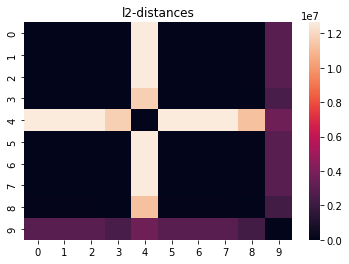

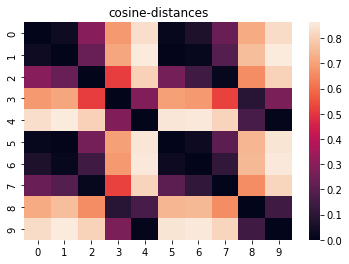

Off matrix diagonal margin: 9.078291893005371
Off matrix diagonal margin: 0.005000000353902578


In [17]:
def show_distances_heatmap(graphs, model):

    model.eval()
    all_embeddings = model.get_embedding(graphs)

    l2_dists = pairwise_l2_distance(all_embeddings)

    rounding_constant = 10 ** 3
    cos_dists = torch.round(calculate_energy_based_hidden_rep(all_embeddings, threshold=-1) * rounding_constant) / rounding_constant

    show_distance_matrix(l2_dists, "l2-distances")
    show_distance_matrix(cos_dists, "cosine-distances")
    print(f"Off matrix diagonal margin: {get_min_non_diagonal_entry(l2_dists)}")
    print(f"Off matrix diagonal margin: {get_min_non_diagonal_entry(cos_dists)}")

show_distances_heatmap(graphs, model)

Add ged=1 examples as positive examples

In [18]:
import networkx as nx


def generate_perturbed_graphs(reference_graph: nx.Graph):
    # assumption: there are no self loops, and no duplicate edges of opposite directions

    # graphs generated by removing an existing edge
    for edge in reference_graph.edges:
        copy_graph = reference_graph.copy()
        copy_graph.remove_edge(*edge)
        yield copy_graph

    # graphs generated by adding a missing edge
    sorted_nodes = sorted(reference_graph.nodes, reverse=False)
    for i, node_i in enumerate(sorted_nodes):
        if i == len(sorted_nodes) - 1:
            break

        for node_j in sorted_nodes[i+1:]:
            edge = (node_i, node_j)
            if reference_graph.has_edge(*edge):
                continue
            copy_graph = reference_graph.copy()
            copy_graph.add_edge(*edge)
            yield copy_graph

# generate subgraphs for which ged(subgraph, reference_subgraph)==1
perturbed_graphs = list(generate_perturbed_graphs(reference_subgraph.G_sub))
for perturbed_graph in perturbed_graphs:
    is_negative_example = False

    G1_annotated = AnnotatedGraph(perturbed_graph)
    G2_annotated = AnnotatedGraph(reference_subgraph.G)
    train_samples_list.append(Pair_Sample_Info(
        subgraph=G1_annotated,
        masked_graph=G2_annotated,
        is_negative_sample=torch.tensor(is_negative_example)))

In [19]:
len(train_samples_list)

101

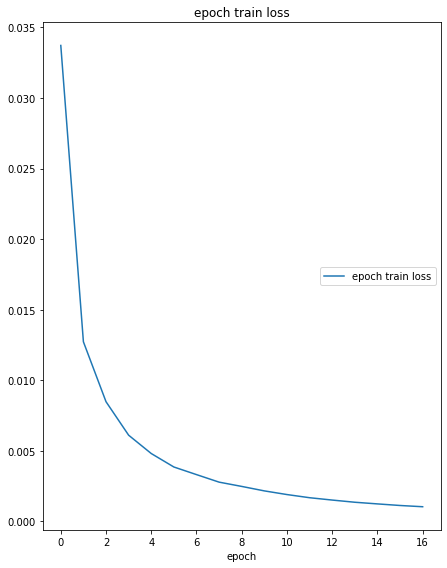

epoch train loss
	epoch train loss 	 (min:    0.001, max:    0.034, cur:    0.001)


([24.44997215270996,
  24.44997215270996,
  21.232196807861328,
  12.673956871032715,
  1.0607470273971558,
  10.127384185791016,
  0.6174498796463013,
  8.256926536560059,
  0.46382081508636475,
  0.8415629863739014,
  2.4532649517059326,
  0.5759093165397644,
  0.31680476665496826,
  0.18548832833766937,
  0.13661041855812073,
  0.11687684059143066,
  0.10740308463573456,
  0.10104292631149292,
  0.09535403549671173,
  0.09163719415664673,
  0.08985045552253723,
  0.08985045552253723,
  0.08805029094219208,
  0.08480888605117798,
  0.10418879985809326,
  0.07743583619594574,
  0.07381448149681091,
  0.06976409256458282,
  0.06482511758804321,
  0.06120917573571205,
  0.06003114581108093,
  0.056579723954200745,
  0.04918528348207474,
  0.041937462985515594,
  0.03785993158817291,
  0.03636544197797775,
  0.03552570939064026,
  0.03480621427297592,
  0.0343908965587616,
  0.03409481421113014,
  0.03427891433238983,
  0.03427891433238983,
  0.0337936207652092,
  0.03351346403360367,
  

In [20]:
val_samples_list = train_samples_list
model = GraphCNN(num_layers=5, num_mlp_layers = 2, input_dim=input_dim, hidden_dim=64, output_dim=num_classes, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device).to(device)
solver_params["batch_size"] = len(train_samples_list)

trainer, graph_metric_nn = init_embedding_net_and_trainer(model)

trainer.train(train_samples_list, val_samples_list)

In [21]:
def generate_s2v_graphs(networkx_graphs, print_stats=True):
    g_list = []
    label_dict = {}
    for networkx_graph in networkx_graphs:
        g_list.append(S2VGraph(networkx_graph, label=None))

        if not label in label_dict:
            mapped = len(label_dict)
            label_dict[label] = mapped

    graphs, _ = load_data_given_graph_list_and_label_map(g_list, label_dict, degree_as_tag=True, device=device, print_stats=print_stats)
    for s2v_graph in graphs:
        # convert graph features here, not only in trainer! (heatmap is probably wrong)
        annotated_graph = AnnotatedGraph(s2v_graph.g)
        s2v_graph.node_features = annotated_graph.node_indicator.to(device=device)

    return graphs

# classes: 1
# maximum node tag: 49
# data: 101


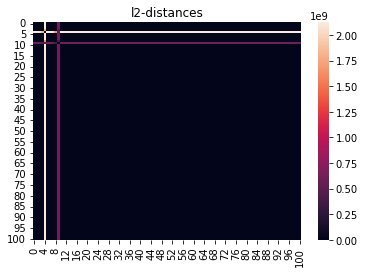

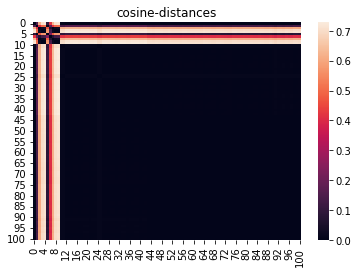

Off matrix diagonal margin: 5.719869022868806e-13
Off matrix diagonal margin: 0.0


In [22]:
all_s2v_graphs = generate_s2v_graphs([subgraph.G for subgraph in subgraphs] + perturbed_graphs)
show_distances_heatmap(all_s2v_graphs, model)

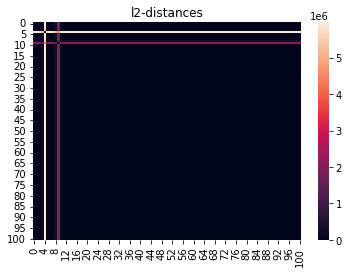

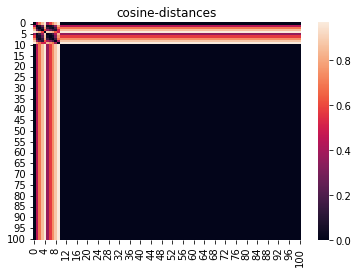

Off matrix diagonal margin: 1.1368683772161603e-13
Off matrix diagonal margin: 0.0


In [23]:
show_distances_heatmap(all_s2v_graphs, model)

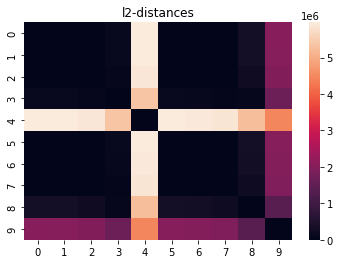

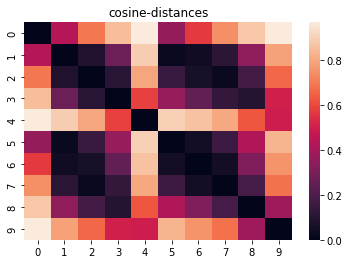

Off matrix diagonal margin: 35.996517181396484
Off matrix diagonal margin: 0.023000001907348633


In [25]:
show_distances_heatmap(all_s2v_graphs[:len(subgraphs)], model)

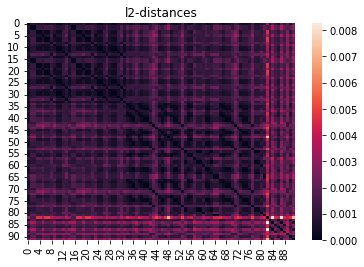

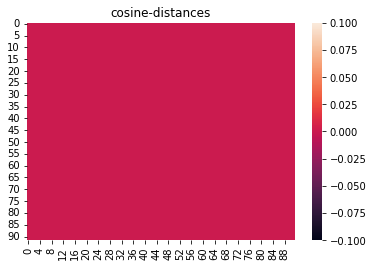

Off matrix diagonal margin: 1.1368683772161603e-13
Off matrix diagonal margin: 0.0


In [26]:
reference_s2v_graph = all_s2v_graphs[reference_subgraph_index]
reference_graph_with_positive_examples = [reference_s2v_graph] + all_s2v_graphs[len(subgraphs):]
reference_graph_with_negative_examples = [all_s2v_graphs[i] for i in range(len(all_s2v_graphs[:len(subgraphs)])) if i != reference_subgraph_index]

show_distances_heatmap(reference_graph_with_positive_examples, model)

In [27]:
all_embeddings = model.get_embedding(reference_graph_with_positive_examples)
l2_dists = pairwise_l2_distance(all_embeddings)

In [28]:
model.eval()

GraphCNN(
  (mlps): ModuleList(
    (0): MLP(
      (linears): ModuleList(
        (0): Linear(in_features=1, out_features=64, bias=True)
        (1): Linear(in_features=64, out_features=64, bias=True)
      )
      (batch_norms): ModuleList(
        (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): MLP(
      (linears): ModuleList(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): Linear(in_features=64, out_features=64, bias=True)
      )
      (batch_norms): ModuleList(
        (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): MLP(
      (linears): ModuleList(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): Linear(in_features=64, out_features=64, bias=True)
      )
      (batch_norms): ModuleList(
        (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): MLP

In [29]:
positive_distances = []
for positive_example_second_graph in reference_graph_with_positive_examples:
    distance = graph_metric_nn.forward([(reference_s2v_graph, positive_example_second_graph)]).item()
    positive_distances.append(distance)
    if distance > solver_params['margin_loss_margin_value']:
        print(f"positive loss term not zero, as distance for this positive example pair is {distance}")

negative_distances = []
for negative_example_second_graph in reference_graph_with_negative_examples:
    distance = graph_metric_nn.forward([(reference_s2v_graph, negative_example_second_graph)]).item()
    negative_distances.append(distance)
    if distance < solver_params['margin_loss_margin_value']:
        print(f"negative loss term not zero, as distance for this negative example pair is {distance}")

In [30]:
max(positive_distances)

5.0505492254160345e-05

In [31]:
min(negative_distances)

5.373362064361572